Let's download the data from INSEE.

In [15]:
code = '107'
# create a dictionary with the translations
longNameOfDiscriminatingColumn = "occupancy status of the main residence"
# create a dictionary with the translations
translations = {'P': 'Owner',
                'L': 'Renter'}


nameOfDiscriminatingColumn = "STATUT"


In [16]:
import pandas as pd


url = f"https://www.insee.fr/fr/statistiques/fichier/4648335/TF{code}.csv"

df = pd.read_csv(url, sep=";")

In [17]:
df = df.loc[df[nameOfDiscriminatingColumn].isin(['P', 'L'])]

In [18]:
df = df.drop(df[df[f'{nameOfDiscriminatingColumn}'] == 'TOT'].index)

In [19]:
# filtering values with exactly 4 characters, corresponding to ECOICOP classes
df = df.loc[df['NOMENCLATURE'].str.len() == 4]

In [20]:
# renaming the "NOMENCLATURE" column to "FCOICOP"
df = df.rename(columns={'NOMENCLATURE': 'FCOICOP'})

In [21]:
# filtering out rows where the "FCOIC" value starts with "13"
df = df.loc[~df['FCOICOP'].str.startswith('13')]

In [22]:
# replace the values in the "STRATE" column with the corresponding translations
df[f'{nameOfDiscriminatingColumn}'] = df[f'{nameOfDiscriminatingColumn}'].replace(translations)

In [23]:
# loading the second csv file with the "FCOICOP" column
df2 = pd.read_csv('Nomenclature_classes_to_special_aggregates.csv')

In [24]:
# merging the two dataframes on the "FCOICOP" column
merged_df = pd.merge(df, df2, on='FCOICOP')

In [25]:
# calculating the sum of "CONSO" for each unique value in "STRATE" column
sum_by_strate = merged_df.groupby(f'{nameOfDiscriminatingColumn}')['CONSO'].sum()

In [26]:
# adding a new column "PROP" with the percentage of each row relative to the sum for each unique value in "STRATE" column
merged_df['PROP'] = merged_df['CONSO'] / merged_df[f'{nameOfDiscriminatingColumn}'].map(sum_by_strate)

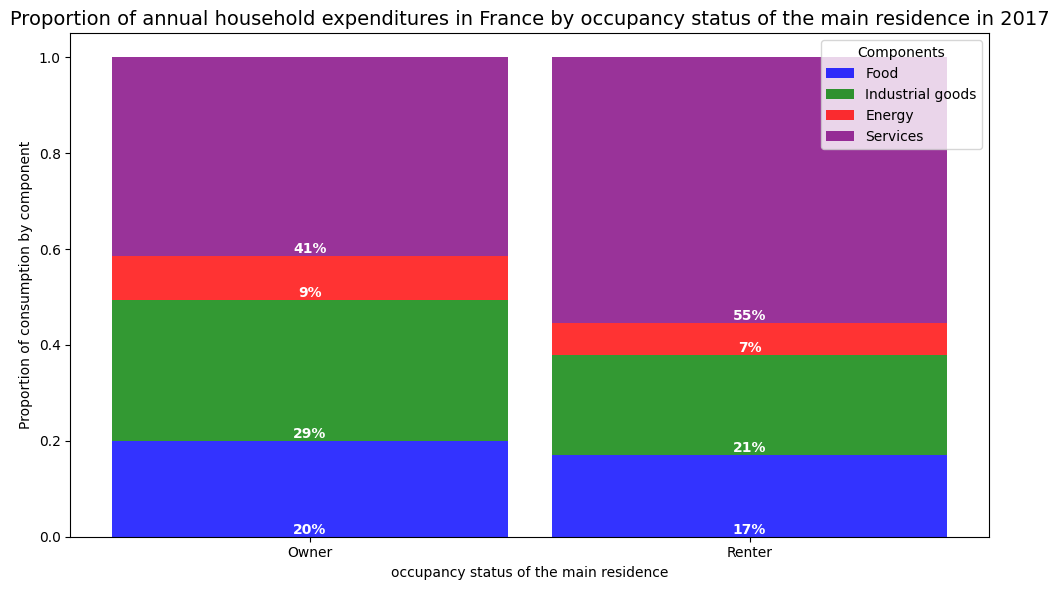

In [27]:
import matplotlib.pyplot as plt

# group the merged dataframe by "AGGREGATE" and "STRATE" and sum the values in the "PROP" column for each group
grouped_df = merged_df.groupby(['AGGREGATE', f'{nameOfDiscriminatingColumn}'])['PROP'].sum().reset_index()


# create a new column "STRATE_SORTED" with values sorted in a specific order
category_order = translations_list = list(translations.values())
grouped_df[f'{nameOfDiscriminatingColumn}_SORTED'] = pd.Categorical(grouped_df[f'{nameOfDiscriminatingColumn}'], categories=category_order, ordered=True)

# pivot the dataframe to create a table where each row represents a STRATE, and each column represents an AGGREGATE with the values in the "PROP" column
pivoted_df = grouped_df.pivot(index=f'{nameOfDiscriminatingColumn}_SORTED', columns='AGGREGATE', values='PROP').fillna(0)


# calculate the cumulative sum of the values in the pivoted dataframe
cumulative_df = pivoted_df.cumsum(axis=1)



# create a stacked bar chart with a bar for each STRATE and bars of colors with sizes proportional to PROP for each AGGREGATE
fig, ax = plt.subplots(figsize=(10, 6))

for i, (colname, color) in enumerate(zip(pivoted_df.columns, ['blue', 'green', 'red', 'purple'])):
    ax.bar(pivoted_df.index, pivoted_df[colname], bottom=cumulative_df.iloc[:, i-1] if i>0 else None, width=0.9, color=color, alpha=0.8, label=colname)
    # Add text labels for each bar
    for j, val in enumerate(pivoted_df[colname]):
        if val > 0:
            ax.text(j, cumulative_df.iloc[j, i-1] if i>0 else 0, f"{round(val*100)}%", ha='center', va='bottom', color='white', fontweight='bold')

# change the legend labels using a dictionary
legend_labels = {'FOOD': 'Food', 'IGD': 'Industrial goods', 'SERV': 'Services', 'NRG': 'Energy'}
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] if label in legend_labels else label for label in labels]
ax.legend(handles, new_labels, title="Components")

ax.set_xlabel(f"{longNameOfDiscriminatingColumn}")
ax.set_ylabel("Proportion of consumption by component")
plt.title(f"Proportion of annual household expenditures in France by {longNameOfDiscriminatingColumn} in 2017", fontsize=14)

plt.tight_layout()
plt.show()
